In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           #"device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly
           "device": torch.device("cpu")}

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

###########

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

C:\Users\user\AppData\Local\Temp\ipykernel_52072\2959601437.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


In [2]:
from mpl_toolkits.mplot3d import axes3d

class MyAxes3D(axes3d.Axes3D):

    def __init__(self, baseObject, sides_to_draw):
        self.__class__ = type(baseObject.__class__.__name__,
                              (self.__class__, baseObject.__class__),
                              {})
        self.__dict__ = baseObject.__dict__
        self.sides_to_draw = list(sides_to_draw)
        self.mouse_init()

    def set_some_features_visibility(self, visible):
        for t in self.w_zaxis.get_ticklines() + self.w_zaxis.get_ticklabels():
            t.set_visible(visible)
        self.w_zaxis.line.set_visible(visible)
        self.w_zaxis.pane.set_visible(visible)
        self.w_zaxis.label.set_visible(visible)

    def draw(self, renderer):
        # set visibility of some features False 
        self.set_some_features_visibility(False)
        # draw the axes
        super(MyAxes3D, self).draw(renderer)
        # set visibility of some features True. 
        # This could be adapted to set your features to desired visibility, 
        # e.g. storing the previous values and restoring the values
        self.set_some_features_visibility(True)

        zaxis = self.zaxis
        draw_grid_old = zaxis.axes._draw_grid
        # disable draw grid
        zaxis.axes._draw_grid = False

        tmp_planes = zaxis._PLANES

        if 'l' in self.sides_to_draw :
            # draw zaxis on the left side
            zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                             tmp_planes[0], tmp_planes[1],
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)
        if 'r' in self.sides_to_draw :
            # draw zaxis on the right side
            zaxis._PLANES = (tmp_planes[3], tmp_planes[2], 
                             tmp_planes[1], tmp_planes[0], 
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)

        zaxis._PLANES = tmp_planes

        # disable draw grid
        zaxis.axes._draw_grid = draw_grid_old

In [3]:
n_var = 5
n_obj = 3
n_constr = 2

ref_point = torch.tensor([0, 0, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

INITIAL_SIZE = 12
N_BATCH = 15
BATCH_SIZE = 4

batch_number = torch.cat([torch.zeros(INITIAL_SIZE),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels


Text(0.5, 1.0, 'Iteration')

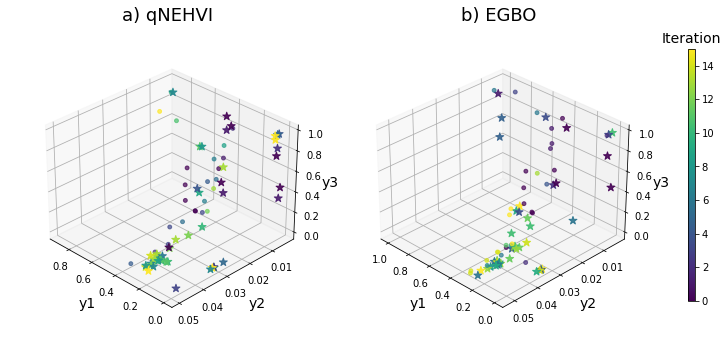

In [4]:
df1 = pd.read_csv('Results_Algo1_Run15.csv')
df2 = pd.read_csv('Results_Algo2_Run15.csv')

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

for ax, df, title in zip([ax1,ax2], [df1, df2], ["a) qNEHVI", "b) EGBO"]):
    initial_torch = torch.tensor(df.iloc[:, 1:].values, **tkwargs)
    train_obj = initial_torch[:,n_var:n_var+n_obj]

    mask = is_non_dominated(train_obj)
    pf = train_obj[mask]
    non_pf = train_obj[~mask]

    num_pf = batch_number[mask]
    num_non_pf = batch_number[~mask]

    ax.scatter3D(pf.cpu().numpy()[:,0],
                 pf.cpu().numpy()[:,1],
                 pf.cpu().numpy()[:,2],
                 c=num_pf, cmap='viridis', s=15, alpha=0.7)

    ax.scatter3D(non_pf.cpu().numpy()[:,0],
                 non_pf.cpu().numpy()[:,1],
                 non_pf.cpu().numpy()[:,2],
                 c=num_non_pf, cmap='viridis', s=70, alpha=0.9, marker='*')


    ax.set_title(f"{title}", fontsize=18)
    ax.set_xlabel('y1', labelpad=8, fontsize=14)
    ax.set_ylabel('y2', labelpad=8, fontsize=14)
    ax.set_zlabel('y3', labelpad=2, fontsize=14)
    #ax.set_xlim(obj1min, obj1max)
    #ax.set_ylim(obj2min, obj2max)

    ax.view_init(azim=135)
    ax.set_box_aspect(aspect=(4, 4, 3), zoom=0.85)
    
plt.tight_layout()

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.96, 0.17, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=14)


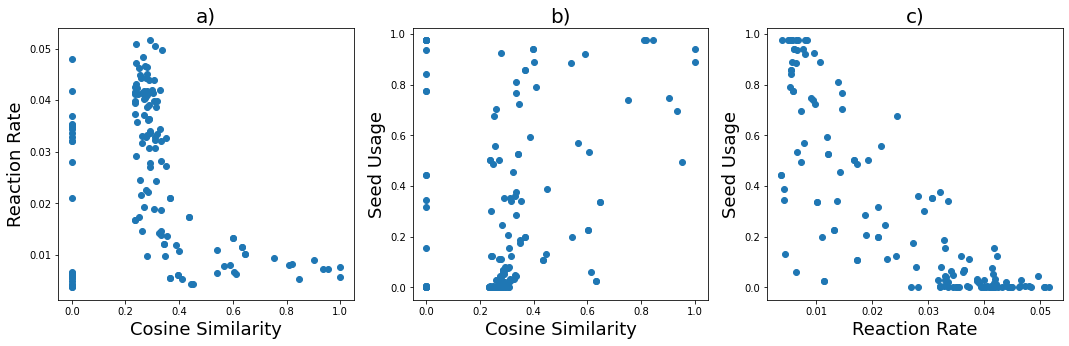

In [9]:
n_var = 5
n_obj = 3
n_constr = 2

INITIAL_SIZE = 12
N_BATCH = 15
BATCH_SIZE = 4

df1 = pd.read_csv('Results_Algo1_Run15.csv').iloc[:,1+n_var:1+n_var+n_obj].to_numpy()
df2 = pd.read_csv('Results_Algo2_Run15.csv').iloc[:,1+n_var:1+n_var+n_obj].to_numpy()

df3 = np.vstack([df1, df2])

fig, axes = plt.subplots(ncols = 3, figsize = (18,5))


for i, ax, label1, labelx, labely, value1, value2 in zip([0,1,2], axes,
                                          ['a)','b)', 'c)'],
                                          ['Cosine Similarity', 'Cosine Similarity', 'Reaction Rate'],
                                          ['Reaction Rate', 'Seed Usage', 'Seed Usage'],[0,0,1], [1,2,2]):
    
    ax.scatter(df3[:,value1], df3[:,value2])
    
    ax.set_title(f"{label1}", fontsize=20)
    ax.set_xlabel(f"{labelx}")
    ax.set_ylabel(f"{labely}")
            